In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import dask.distributed as dd

import vcm
from loaders.mappers._nudged._nudged import open_nudge_to_fine_scream
from loaders.batches._batch import batches_from_mapper

In [2]:
client = dd.Client(n_workers=16, threads_per_worker=2, memory_limit='2GB')

In [3]:
plt.rcParams['figure.dpi'] = 120

In [4]:
path = "/pscratch/sd/a/andrep/Corrective-ML/nudged_sim_with_fixed_radation_from_ne120"
ds = xr.open_zarr(f"{path}/state_after_timestep.zarr")

In [5]:
frac_vars = [
    "sfc_flux_dir_nir",
    "sfc_flux_dir_vis",
    "sfc_flux_dif_nir",
    "sfc_flux_dif_vis",
]

# no locations where TOA is == 0 and sfc is > 0
# only check locations where TOA is > 0

mask = ds.SW_flux_dn_at_model_top > 0
sfc_sw_dn = ds.SW_flux_dn_at_model_bot.where(mask)

In [6]:
component_dn_fracs = xr.Dataset({f"{var}_frac": (ds[var].where(mask) / sfc_sw_dn).compute() for var in frac_vars})

In [15]:
for i, (k, v) in enumerate(component_dn_fracs.items()):
    if i == 0:
        summed = v
    else:
        summed += v

(array([7.6000000e+01, 0.0000000e+00, 8.2105200e+05, 5.0840900e+06,
        0.0000000e+00, 3.2339217e+07, 0.0000000e+00, 0.0000000e+00,
        1.2978460e+06, 2.0000000e+00]),
 array([0.9999998 , 0.9999999 , 0.9999999 , 0.99999994, 1.        ,
        1.        , 1.0000001 , 1.0000001 , 1.0000001 , 1.0000002 ,
        1.0000002 ], dtype=float32),
 <a list of 10 Patch objects>)

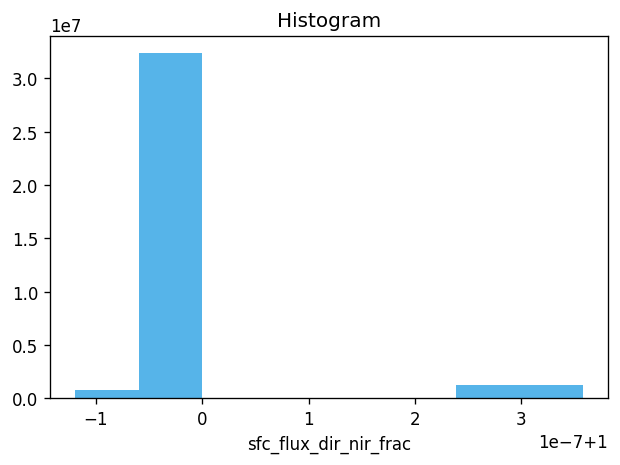

In [16]:
summed.plot.hist()

## Check the relationship between vis / NIR 

In [7]:
total_nir = component_dn_fracs.sfc_flux_dif_nir_frac + component_dn_fracs.sfc_flux_dir_nir_frac
total_vis = component_dn_fracs.sfc_flux_dif_vis_frac + component_dn_fracs.sfc_flux_dir_vis_frac

In [8]:
component_dn_fracs["total_nir_frac"] = total_nir
component_dn_fracs["total_vis_frac"] = total_vis

In [9]:
component_dn_fracs["nir_dif_frac"] = component_dn_fracs.sfc_flux_dif_nir_frac / total_nir
component_dn_fracs["vis_dif_frac"] = component_dn_fracs.sfc_flux_dif_vis_frac / total_vis

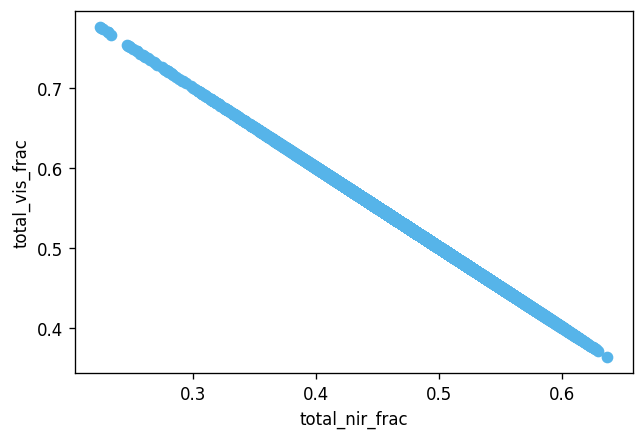

In [26]:
component_dn_fracs.where(mask).isel(time=slice(10)).plot.scatter(x="total_nir_frac", y="total_vis_frac")
plt.show()

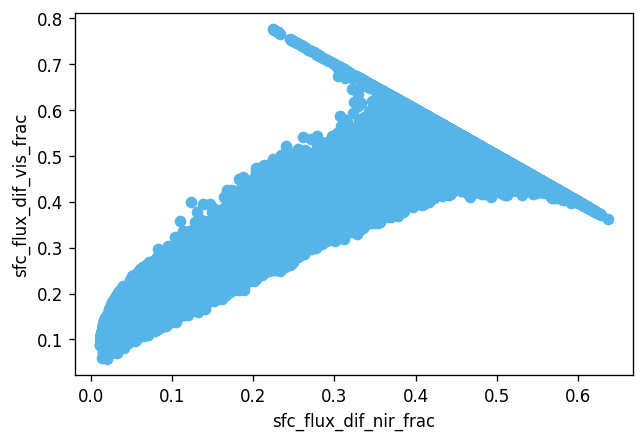

In [27]:
component_dn_fracs.where(mask).isel(time=slice(10)).plot.scatter(x="sfc_flux_dif_nir_frac", y="sfc_flux_dif_vis_frac")
plt.show()

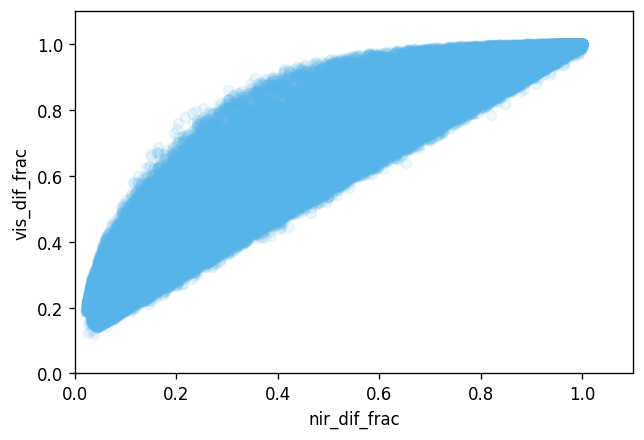

In [32]:
component_dn_fracs.where(mask).isel(time=slice(10)).plot.scatter(x="nir_dif_frac", y="vis_dif_frac", alpha=0.1)
plt.ylim(0, 1.1)
plt.xlim(0, 1.1)
plt.show()

Predict transmissivity, predict total_vis frac and determine total_nir frac from that.  Then predict the vis diffuse and the nir diffuse.  NIR must <= the vis_diffuse.  So just add a min argument to the model or clip config?

In [6]:
mapper = open_nudge_to_fine_scream(
    path,
    ["T_mid", "qv", "U", "V"],
    1800
)
var_names = [
"sfc_flux_dir_nir",
"sfc_flux_dir_vis",
"sfc_flux_dif_nir",
"sfc_flux_dif_vis",
"sfc_flux_sw_net",
"sfc_flux_lw_dn",
"shortwave_transmissivity_of_atmospheric_column",
"total_sky_downward_shortwave_flux_at_top_of_atmosphere",
"total_sky_downward_shortwave_flux_at_surface",
"downward_visible_fraction_at_surface",
"downward_nir_fraction_at_surface",
"downward_vis_diffuse_fraction_at_surface",
"downward_vis_direct_fraction_at_surface",
"downward_nir_diffuse_fraction_at_surface",
"downward_nir_direct_fraction_at_surface",
]
batches = batches_from_mapper(
    mapper,
    var_names,
    unstacked_dims=["z"],
    drop_nans=True
)

In [7]:
tmp = batches[0]

In [8]:
tmp.load()

<xarray.Dataset>
Dimensions:                                                 (_fv3net_sample: 13624)
Coordinates:
  * _fv3net_sample                                          (_fv3net_sample) MultiIndex
  - time                                                    (_fv3net_sample) object ...
  - ncol                                                    (_fv3net_sample) int64 ...
Data variables: (12/15)
    sfc_flux_dir_nir                                        (_fv3net_sample) float32 ...
    sfc_flux_dir_vis                                        (_fv3net_sample) float32 ...
    sfc_flux_dif_nir                                        (_fv3net_sample) float32 ...
    sfc_flux_dif_vis                                        (_fv3net_sample) float32 ...
    sfc_flux_sw_net                                         (_fv3net_sample) float32 ...
    sfc_flux_lw_dn                                          (_fv3net_sample) float32 ...
    ...                                                      ...
    downward_visible_fraction_at_surface                    (_fv3net_sample) float32 ...
    downward_nir_fraction_at_surface                        (_fv3net_sample) float32 ...
    downward_vis_diffuse_fraction_at_surface                (_fv3net_sample) float32 ...
    downward_vis_direct_fraction_at_surface                 (_fv3net_sample) float32 ...
    downward_nir_diffuse_fraction_at_surface                (_fv3net_sample) float32 ...
    downward_nir_direct_fraction_at_surface                 (_fv3net_sample) float32 ...

In [11]:
tmp["downward_nir_diffuse_fraction_at_surface"] + tmp["downward_nir_direct_fraction_at_surface"]

<xarray.DataArray (time: 1, ncol: 21600)>
array([[1., 1., 1., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * time     (time) object 2010-12-25 18:00:00
Dimensions without coordinates: ncol

In [12]:
tmp["downward_nir_fraction_at_surface"] + tmp["downward_visible_fraction_at_surface"]

<xarray.DataArray (time: 1, ncol: 21600)>
array([[1., 1., 1., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
  * time     (time) object 2010-12-25 18:00:00
Dimensions without coordinates: ncol

In [12]:
a = derived["downward_nir_diffuse_fraction"].isel(time=slice(100)).compute()
b = derived["downward_nir_direct_fraction"].isel(time=slice(100)).compute()

KeyError: 'downward_nir_diffuse_fraction'

In [ ]:
a = derived["downward_vis_diffuse_fraction"].isel(time=slice(100)).compute()